## Gradient Descent 2-DoF Planar Arm
This script implements a simple Gradient Descent (GD) based Inverse Kinematics (IK).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import imageio
from IPython.display import display, clear_output

We define a function that computes the end-effector forward kinematics for a 2-DOF planar arm:

$$\begin{bmatrix}x \\ y \\ \phi \end{bmatrix} = \begin{bmatrix}l_1 c_{q_0} + l_2 c_{q_0 q_1} \\ l_1 s_{q_0} + l_2 s_{q_0 q_1} \\ q_0 + q_1\phi \end{bmatrix}$$


**Parameters:**

$q_0$: float Joint angle 0 in radians.

$q_1$: float Joint angle 1 in radians.

$l_1$: float Length of link 1.

$l_2$: float Length of link 2.

**Return:**

np.array $[x, y, \phi]$ where $(x, y)$ is the end-effector position and $\phi$ is the orientation.

In [2]:
def fk_ee(q0, q1, l1=1.0, l2=1.0):
    x = l1 * np.cos(q0) + l2 * np.cos(q0 + q1)
    y = l1 * np.sin(q0) + l2 * np.sin(q0 + q1)
    fi = q0 + q1
    return np.array([x, y, fi])


We define another function that computes the full forward kinematics (in terms of position) for a 2-DOF planar arm:

$$\begin{bmatrix}x_0 \\ y_0 \end{bmatrix} = \begin{bmatrix}l_1 c_{q_0} \\ l_1 s_{q_0} \end{bmatrix}$$

and

$$\begin{bmatrix}x_1 \\ y_1 \end{bmatrix} = \begin{bmatrix}l_1 c_{q_0} + l_2 c_{q_0 q_1} \\ l_1 s_{q_0} + l_2 s_{q_0 q_1} \end{bmatrix}$$

**Parameters:**

$q_0$: float Joint angle 0 in radians.

$q_1$: float Joint angle 1 in radians.

$l_1$: float Length of link 1.

$l_2$: float Length of link 2.

**Return:**

$x_0$, $y_0$, $x_1$, $y_1$ where $(x_0, y_0)$ is the position of joint 1 and $(x_1, $y_1)$ is the position of the end-effector.

In [3]:
def full_fk(q0, q1, l1=1.0, l2=1.0):
    x0 = l1 * np.cos(q0)
    y0 = l1 * np.sin(q0)
    x1 = x0 + l2 * np.cos(q0 + q1)
    y1 = y0 + l2 * np.sin(q0 + q1)

    return x0, y0, x1, y1

We now define a function to compute the Jacobian matrix $\mathbf{J}(\mathbf{q}) \in \mathbb{R}^{3 \times 2}$ for the 2-DOF planar arm:

$$\mathbf{J}(\mathbf{q}) = \begin{bmatrix}-l_1 s_{q_0}-l_2 s_{q_0 q_1} & -l_2 s_{q_0 q_1} \\
l_1 c_{q_0}+l_2 c_{q_0 q_1} & l_2 c_{q_0 q_1} \\
1 & 1\end{bmatrix}$$

**Parameters:**
    
$q_0$: float Joint angle 0 in radians.

$q_1$: float Joint angle 1 in radians.

$l_1$: float Length of link 1.

$l_2$: float Length of link 2.

**Return:**

The Jacobian matrix $\mathbf{J}(\mathbf{q}) \in \mathbb{R}^{3 \times 2}$.

In [4]:
def compute_jacobian(q0, q1, l1=1.0, l2=1.0):
    J = np.zeros((3, 2))
    J[0, 0] = -l1 * np.sin(q0) - l2 * np.sin(q0 + q1)
    J[0, 1] = -l2 * np.sin(q0 + q1)
    J[1, 0] = l1 * np.cos(q0) + l2 * np.cos(q0 + q1)
    J[1, 1] = l2 * np.cos(q0 + q1)
    J[2, 0] = 1
    J[2, 1] = 1
    return J

The following function is the GD loop for the IK.
At each iteration, it computes the joint angles required to reach a target end-effector position using gradient descent:

$$\mathbf{q}_{i+1} = \mathbf{q}_i + \sigma \mathbf{J}(\mathbf{q})^T \left( \mathbf{p}_{target} - \mathbf{p} \right)$$

**Parameters:**
    
$\mathbf{p}_{target}$: $\in \mathbb{R}^{2}$ target to reach
    
$\mathbf{q}_i$: $\in \mathbb{R}^{2}$ initial joint angles in radians.
    
$control\_idx$: list of indices indicating which dimensions of the end-effector to control (0 for $x$, 1 for $y$, 2 for $\phi$).

$l_1$: float Length of link 1.

$l_2$: float Length of link 2.
    
$\sigma$: float learning rate
    
$tol$: float tolerance for convergence.
    
$max\_iters$: int maximum number of iterations.
    
$visualize$: bool whether to visualize the process.
    
**Return:**

$\mathbf{q}$, $fk\_ee(q[0], q[1], l_1, l_2)$, $cost$

where $\mathbf{q}$ is the final joint angles, $fk\_ee$ is the final end-effector position, and $cost$ is the final cost.

In [5]:
def gradient_descent_ik(
    target,
    initial_q,
    control_idx=[0, 1],
    l1=1.0,
    l2=1.0,
    sigma=0.1,
    tol=1e-6,
    max_iters=1000,
    visualize=True,
    pause_time=0.01,
):
    log = []

    # -------------------------
    # Input validation
    # -------------------------
    if len(control_idx) != 2:
        raise ValueError("control_idx must have exactly two elements for a 2-DOF arm.")
    if control_idx[0] > control_idx[1]:
        raise ValueError("control_idx must be in ascending order.")
    if control_idx[0] < 0 or control_idx[1] > 2:
        raise ValueError("control_idx values must be in the range [0, 2].")
    if target.shape[0] != 2:
        raise ValueError("target must be a 2D vector.")

    q = np.array(initial_q, dtype=float)

    # -------------------------
    # Visualization setup
    # -------------------------
    if visualize:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(-(l1 + l2) - 0.5, (l1 + l2) + 0.5)
        ax.set_ylim(-(l1 + l2) - 0.5, (l1 + l2) + 0.5)
        ax.set_aspect("equal")
        ax.grid(True)

        ax.plot(target[0], target[1], "rx", markersize=10, label="Target")
        line, = ax.plot([], [], "o-", linewidth=3, label="Arm")
        ax.legend()

        frames = []

    # -------------------------
    # Gradient descent loop
    # -------------------------
    for k in range(max_iters):
        current_pos = fk_ee(q[0], q[1], l1, l2)
        error = target - np.array([current_pos[i] for i in control_idx])
        cost = np.linalg.norm(error)

        log.append([q[0], q[1], current_pos[0], current_pos[1], sigma, cost])

        if cost < tol:
            break

        J = compute_jacobian(q[0], q[1], l1, l2)[control_idx]
        q += sigma * J.T @ error

        # -------------------------
        # Real-time animation (Jupyter)
        # -------------------------
        if visualize:
            x1, y1, x2, y2 = full_fk(q[0], q[1], l1, l2)
            line.set_data([0, x1, x2], [0, y1, y2])
            ax.set_title(f"Iteration {k}, cost = {cost:.3e}")

            clear_output(wait=True)
            display(fig)

            fig.canvas.draw()
            frame = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
            frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
            frame = frame[:, :, 1:4]  # ARGB → RGB
            frames.append(frame)

            plt.pause(pause_time)

    # -------------------------
    # Save log
    # -------------------------
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    log_file = f"gradient_descent_2dofs_arm_log_{timestamp}.csv"

    with open(log_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["q0", "q1", "x", "y", "sigma", "cost"])
        writer.writerows(log)

    print(f"Saved joint values to {log_file}")

    # -------------------------
    # Save GIF
    # -------------------------
    if visualize and len(frames) > 0:
        gif_name = f"gd_2dofs_arm_{timestamp}.gif"
        imageio.mimsave(gif_name, frames, fps=int(1 / pause_time))
        print(f"Saved GIF: {gif_name}")

    return q, fk_ee(q[0], q[1], l1, l2), cost


# Execution example:
We select a ```target``` and ```initial_q```.

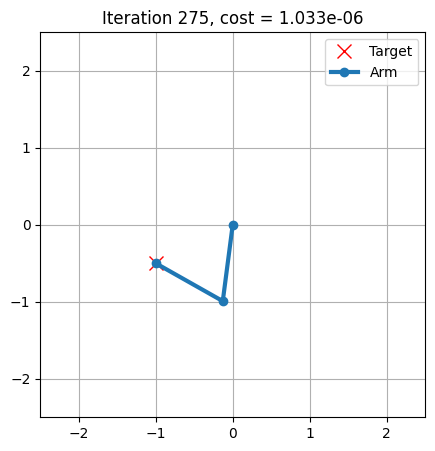

Saved joint values to gradient_descent_2dofs_arm_log_2025-12-27_15-00-59.csv
Saved GIF: gd_2dofs_arm_2025-12-27_15-00-59.gif
Final joint angles: [-1.70034939 -1.95519201]
Final end-effector position: [-1.00000098 -0.50000006 -3.6555414 ]
Final cost: 9.824283070369194e-07


In [6]:
if __name__ == "__main__":
    target = np.array([-1., -0.5])
    initial_q = np.array([.0, .0])
    final_q, final_pos, final_cost = gradient_descent_ik(target, initial_q, sigma=0.1)
    print(f"Final joint angles: {final_q}")
    print(f"Final end-effector position: {final_pos}")
    print(f"Final cost: {final_cost}")

# Plot results

In [7]:
import plots_2dofs_arm

No log files found for pattern clik_2dofs_arm_log_*.csv!


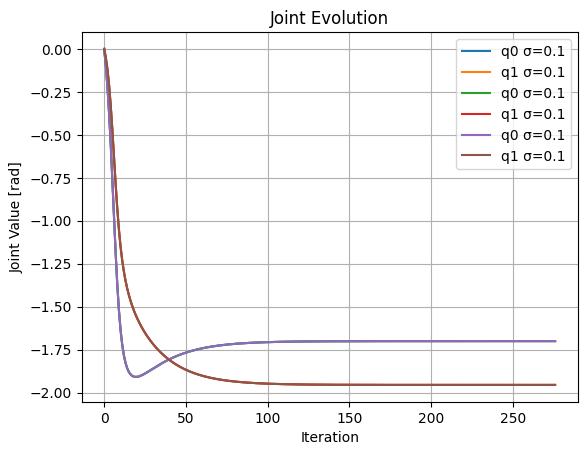

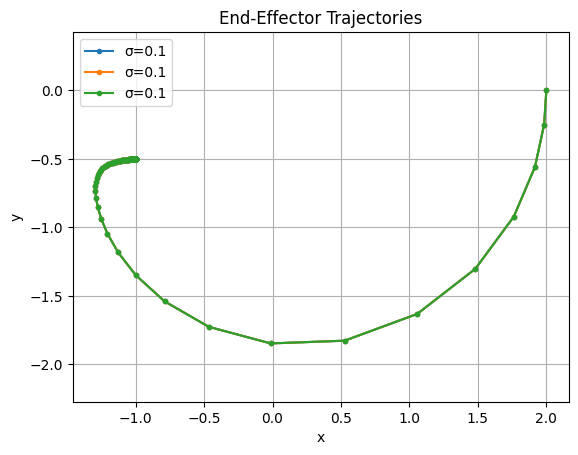

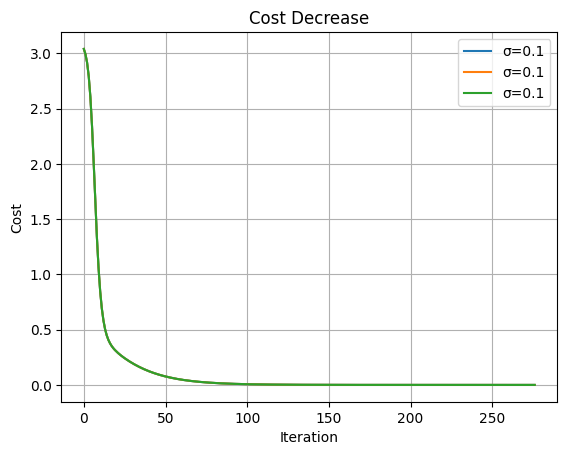

In [8]:
if __name__ == "__main__":
    plots_2dofs_arm.main()